## Stock Price Prediction with Sentiment Analysis

In [1]:
# %%time
# !pip install charset-normalizer pandas_ta yfinance statsmodels tqdm scikit-learn tensorflow

In [2]:
%%time
# To reload the imported modules automatically
%load_ext autoreload
%autoreload 2

CPU times: user 4.08 ms, sys: 4.07 ms, total: 8.16 ms
Wall time: 7.52 ms


In [3]:
%%time
# Import the necessary libraries and modules
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import ReduceLROnPlateau
import warnings
import os

# Import modules
import config as cfg
import data_processing as dp
import sentiment_analysis as sa
import model as mdl
import utils as ut
import time
import keras_tuner as kt
from tqdm import tqdm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

/opt/anaconda3/envs/tf_metal/lib/python3.10/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


CPU times: user 5.32 s, sys: 1.25 s, total: 6.58 s
Wall time: 9.42 s


In [4]:
%%time
start_time = time.time()
warnings.filterwarnings("ignore")
np.random.seed(42)
tf.random.set_seed(42)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
os.makedirs(cfg.DATASET_DIR, exist_ok=True)
print(f"Current working directory: {os.getcwd()}")

Current working directory: /Users/sandy/PycharmProjects/stock_market_analysis
CPU times: user 263 µs, sys: 316 µs, total: 579 µs
Wall time: 652 µs


In [5]:
%%time
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    try:
        # Set memory growth to be the same for all GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

        logical_gpus = tf.config.list_logical_devices("GPU")
        print(
            f"✅ {len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPUs configured with memory growth."
        )

    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(f"Error setting memory growth: {e}")
else:
    print("🤷 No GPU detected. TensorFlow will run on CPU.")

✅ 1 Physical GPUs, 1 Logical GPUs configured with memory growth.
CPU times: user 1.63 ms, sys: 2.78 ms, total: 4.41 ms
Wall time: 11.5 ms


I0000 00:00:1753810875.321370  657320 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1753810875.321681  657320 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### Load and Analyze News Data

In [6]:
%%time
sentiment_csv_path = f"{cfg.DATASET_DIR}/{cfg.STOCK_SYMBOL}_daily_sentiment.csv"

if cfg.UPDATE_SENTIMENT_CSV or not os.path.exists(sentiment_csv_path):
    print("Generating new sentiment data and saving to CSV...")
    news_df = dp.load_and_analyze_news_data(cfg.NEWS_DATA_FILE, cfg.STOCK_SYMBOL)
    company_sentiment_df = sa.process_news_sentiment(news_df, cfg.STOCK_SYMBOL)
    daily_sentiment_df = sa.aggregate_daily_sentiment(company_sentiment_df)
    ut.save_dataframe(daily_sentiment_df, sentiment_csv_path)
else:
    print(f"Loading existing sentiment data from {sentiment_csv_path}...")
    daily_sentiment_df = pd.read_csv(
        sentiment_csv_path, index_col="Date", parse_dates=True
    )

print("Sentiment data ready.")

Loading existing sentiment data from Dataset/NVDA_daily_sentiment.csv...
Sentiment data ready.
CPU times: user 3.42 ms, sys: 2.06 ms, total: 5.47 ms
Wall time: 12.5 ms


### Fetch Stock Data and Calculate Technical Indicators

In [7]:
%%time
START_DATE, END_DATE = ut.calculate_dynamic_date_range(daily_sentiment_df)

stock_filename = f"{cfg.STOCK_SYMBOL}_stock_data_{START_DATE}_to_{END_DATE}.csv"
stock_csv_path = os.path.join(cfg.DATASET_DIR, stock_filename)

if cfg.UPDATE_STOCK_CSV or not os.path.exists(stock_csv_path):
    print(f"Fetching new stock data from yfinance ({START_DATE} to {END_DATE})...")
    stock_data = dp.fetch_stock_data(cfg.STOCK_SYMBOL, START_DATE, END_DATE)
    if stock_data is not None:
        stock_data.to_csv(stock_csv_path)
        print(f"Stock data saved to {stock_csv_path}")
else:
    print(f"Loading existing stock data from {stock_csv_path}...")
    stock_data = pd.read_csv(stock_csv_path, index_col="Date", parse_dates=True)

# Calculate technical indicators from the loaded/fetched data
tech_data = dp.calculate_technical_indicators(stock_data)
print("Technical indicators calculated.")

Fetching new stock data from yfinance (2010-03-03 to 2020-06-10)...
\n📈 Fetching stock data for NVDA...
Successfully fetched 2586 days of data.
Stock data saved to Dataset/NVDA_stock_data_2010-03-03_to_2020-06-10.csv
Technical indicators calculated.
CPU times: user 79.1 ms, sys: 30.5 ms, total: 110 ms
Wall time: 601 ms


### Prepare Data for LSTM & SVM Models

In [8]:
%%time
# Prepare data for models using only technical indicators
X_train_tech, X_test_tech, y_train_tech, y_test_tech, scaler_tech = (
    mdl.prepare_data_for_lstm(
        tech_data,
        cfg.BASELINE_FEATURES,
        cfg.BASELINE_TARGET,
        cfg.SEQUENCE_LENGTH,
        cfg.TEST_SIZE,
    )
)

# Prepare data for models using sentiment + technical indicators
enhanced_full_data = dp.create_enhanced_dataset(tech_data, daily_sentiment_df)
X_train_enh, X_test_enh, y_train_enh, y_test_enh, scaler_enh = (
    mdl.prepare_data_for_lstm(
        enhanced_full_data,
        cfg.ENHANCED_FEATURES,
        cfg.ENHANCED_TARGET,
        cfg.SEQUENCE_LENGTH,
        cfg.TEST_SIZE,
    )
)


🔗 Merging sentiment and technical data...
Enhanced dataset shape: (2387, 35)
CPU times: user 7.45 ms, sys: 2.28 ms, total: 9.72 ms
Wall time: 9.07 ms


### Single Layer LSTM Models

In [9]:
%%time
print("\n--- Tuning Single-Layer LSTM Model ---")

# Define the input shape from your training data
input_shape = (X_train_tech.shape[1], X_train_tech.shape[2])

# Instantiate the tuner, passing the input_shape to the model builder
tuner_single_lstm = kt.Hyperband(
    hypermodel=lambda hp: mdl.build_single_layer_lstm(hp, input_shape=input_shape),
    objective="val_loss",
    max_epochs=20,
    factor=3,
    directory="tuner_results",
    project_name="single_layer_lstm",
    overwrite=True,
)

# Define a callback to stop training early
stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)

# Run the hyperparameter search
print("Starting hyperparameter search...")
tuner_single_lstm.search(
    X_train_tech,
    y_train_tech,
    epochs=50,
    validation_split=0.2,
    callbacks=[stop_early],
    verbose=2,
)
print("\nHyperparameter search complete.")

# Get the optimal hyperparameters and the best model
best_hps_single_lstm = tuner_single_lstm.get_best_hyperparameters(num_trials=1)[0]
single_lstm_model = tuner_single_lstm.get_best_models(num_models=1)[0]

print(
    f"""
---
Optimal Hyperparameters for Single-Layer LSTM:
Units: {best_hps_single_lstm.get('units')}
Dropout: {best_hps_single_lstm.get('dropout'):.2f}
Learning Rate: {best_hps_single_lstm.get('learning_rate')}
---
"""
)

Trial 30 Complete [00h 00m 10s]
val_loss: 0.00952828861773014

Best val_loss So Far: 0.005167611408978701
Total elapsed time: 00h 03m 51s
\nHyperparameter search complete.

---
Optimal Hyperparameters for Single-Layer LSTM:
Units: 224
Dropout: 0.10
Learning Rate: 0.001
---

CPU times: user 2min 54s, sys: 1min 14s, total: 4min 9s
Wall time: 3min 52s



--- Evaluating Best Single-Layer LSTM Model ---
{'Model': 'Single-Layer LSTM', 'RMSE': np.float64(0.4772901853814262), 'MAE': 0.2972302227339485, 'MAPE (%)': np.float64(5.140302831627037), 'R-squared': 0.8799199334411052, 'Directional_Accuracy': np.float64(48.739495798319325), 'MASE': np.float64(63.21647385466809)}
Plot saved to Output/NVDA_Single-Layer_LSTM_analysis.png


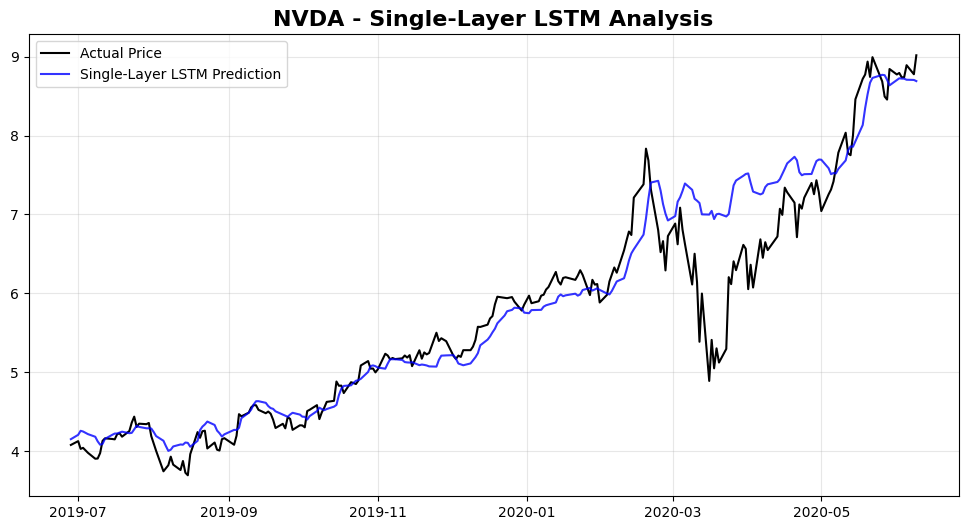

CPU times: user 325 ms, sys: 40.3 ms, total: 365 ms
Wall time: 394 ms


In [10]:
%%time
# --- Evaluation using the best model ---
print("\n--- Evaluating Best Single-Layer LSTM Model ---")
single_layer_lstm_preds = single_lstm_model.predict(X_test_tech, verbose=0)

# Re-create the scaler based on the training data's 'Close' price
close_scaler = MinMaxScaler()
close_scaler.fit(tech_data[["Close"]][: len(X_train_tech)])  # Fit only on the training part

# Inverse transforms the actual and predicted values
y_test_tech_scaled = close_scaler.inverse_transform(y_test_tech.reshape(-1, 1))
base_preds_scaled = close_scaler.inverse_transform(single_layer_lstm_preds)

# Calculate and print metrics
baseline_metrics = ut.calculate_metrics(
    y_test_tech_scaled, base_preds_scaled, "Single-Layer LSTM", y_train_tech
)
print(baseline_metrics)

# Plot the results
test_dates_tech = tech_data.index[-len(y_test_tech_scaled) :]
ut.plot_non_keras_results(
    y_test_tech_scaled,
    base_preds_scaled,
    test_dates_tech,
    cfg.STOCK_SYMBOL,
    "Single-Layer LSTM",
)

### Multi Layer LSTM Models

In [11]:
%%time
print("\n--- Tuning Multi-Layer LSTM Model ---")

# Define the input shape from our training data
input_shape = (X_train_tech.shape[1], X_train_tech.shape[2])

# Instantiate the tuner
tuner_multi_lstm = kt.Hyperband(
    # Pass the input_shape to the model-building function
    hypermodel=lambda hp: mdl.build_multi_layer_lstm(hp, input_shape=input_shape),
    objective="val_loss",
    max_epochs=20,
    factor=3,
    directory="tuner_results",
    project_name="multi_layer_lstm",  # New project name to store results separately
    overwrite=True,
)

# Define a callback to stop training early if val_loss isn't improving
stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)

# Run the hyperparameter search
print("Starting hyperparameter search...")
tuner_multi_lstm.search(
    X_train_tech,
    y_train_tech,
    epochs=50,
    validation_split=0.2,
    callbacks=[stop_early],
    verbose=2,
)
print("\\nHyperparameter search complete.")

# Get the optimal hyperparameters and the best model
best_hps_multi_lstm = tuner_multi_lstm.get_best_hyperparameters(num_trials=1)[0]
multi_layer_model = tuner_multi_lstm.get_best_models(num_models=1)[0]

print(
    f"""
---
Optimal Hyperparameters for Multi-Layer LSTM:
Units Layer 1: {best_hps_multi_lstm.get('units_1')}
Units Layer 2: {best_hps_multi_lstm.get('units_2')}
Dropout: {best_hps_multi_lstm.get('dropout'):.2f}
Learning Rate: {best_hps_multi_lstm.get('learning_rate')}
---
"""
)

Trial 30 Complete [00h 00m 25s]
val_loss: 0.008038992993533611

Best val_loss So Far: 0.0067599122412502766
Total elapsed time: 00h 05m 17s
\nHyperparameter search complete.

---
Optimal Hyperparameters for Multi-Layer LSTM:
Units Layer 1: 192
Units Layer 2: 128
Dropout: 0.50
Learning Rate: 0.0001
---

CPU times: user 4min 26s, sys: 1min 34s, total: 6min 1s
Wall time: 5min 18s



--- Evaluating Best Multi-Layer LSTM Model ---
Plotting results for the best model...
Plot saved to Output/NVDA_Multi-Layer_LSTM_analysis.png


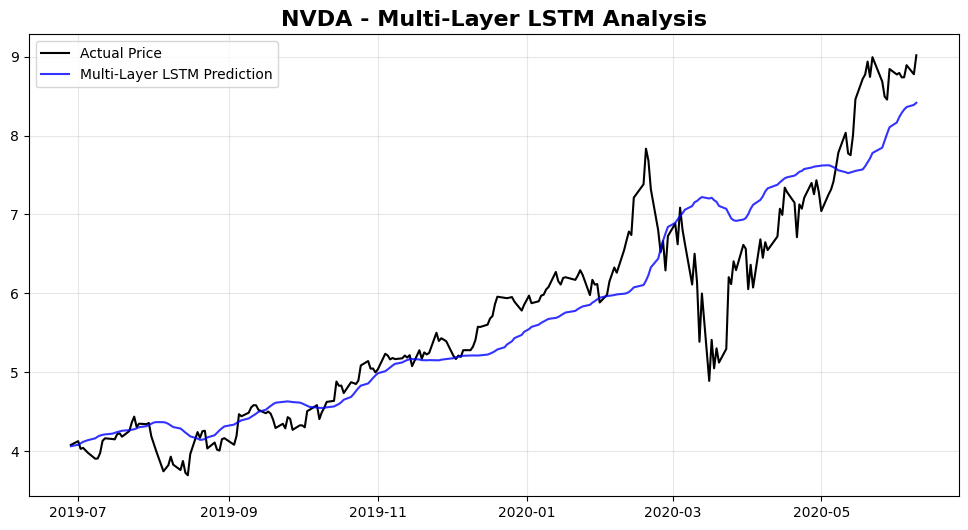

{'Model': 'Multi-Layer LSTM', 'RMSE': np.float64(0.5605323817339922), 'MAE': 0.3844989962158842, 'MAPE (%)': np.float64(6.512709783955947), 'R-squared': 0.8343820802481956, 'Directional_Accuracy': np.float64(53.78151260504202), 'MASE': np.float64(81.77725171368097)}
CPU times: user 543 ms, sys: 51.4 ms, total: 595 ms
Wall time: 794 ms


In [12]:
%%time
# Proceed with evaluation using the best model
print("\n--- Evaluating Best Multi-Layer LSTM Model ---")
multi_preds = multi_layer_model.predict(X_test_tech, verbose=0)

# We can reuse the same scaler fitted before
y_test_tech_scaled = close_scaler.inverse_transform(y_test_tech.reshape(-1, 1))
multi_preds_scaled = close_scaler.inverse_transform(multi_preds)

multi_layer_metrics = ut.calculate_metrics(
    y_test_tech_scaled, multi_preds_scaled, "Multi-Layer LSTM", y_train_tech
)
test_dates_tech = tech_data.index[-len(y_test_tech_scaled) :]

# Plot the results
print("Plotting results for the best model...")
ut.plot_non_keras_results(
    y_test_tech_scaled,
    multi_preds_scaled,
    test_dates_tech,
    cfg.STOCK_SYMBOL,
    "Multi-Layer LSTM",
)

print(multi_layer_metrics)

### Single-Layer Enhanced LSTM Model

In [13]:
%%time
print("\n--- Tuning Single-Layer Enhanced LSTM Model ---")

# Define the input shape from our ENHANCED training data
input_shape = (X_train_enh.shape[1], X_train_enh.shape[2])

# Instantiate the tuner
tuner_enh_single_lstm = kt.Hyperband(
    hypermodel=lambda hp: mdl.build_single_layer_lstm(hp, input_shape=input_shape),
    objective="val_loss",
    max_epochs=20,
    factor=3,
    directory="tuner_results",
    project_name="enhanced_single_layer_lstm",
    overwrite=True,
)

# Define a callback for early stopping
stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)

# Run the hyperparameter search on the ENHANCED data
print("Starting hyperparameter search on enhanced data...")
tuner_enh_single_lstm.search(
    X_train_enh,
    y_train_enh,
    epochs=50,
    validation_split=0.2,
    callbacks=[stop_early],
    verbose=2,
)
print("\\nHyperparameter search complete.")

# Get the optimal hyperparameters and the best model
best_hps_enh_single = tuner_enh_single_lstm.get_best_hyperparameters(num_trials=1)[0]
enhanced_model = tuner_enh_single_lstm.get_best_models(num_models=1)[0]

print(
    f"""
---
Optimal Hyperparameters for Enhanced Single-Layer LSTM:
Units: {best_hps_enh_single.get('units')}
Dropout: {best_hps_enh_single.get('dropout'):.2f}
Learning Rate: {best_hps_enh_single.get('learning_rate')}
---
"""
)

Trial 30 Complete [00h 00m 10s]
val_loss: 0.015023939311504364

Best val_loss So Far: 0.004414282739162445
Total elapsed time: 00h 03m 34s
\nHyperparameter search complete.

---
Optimal Hyperparameters for Enhanced Single-Layer LSTM:
Units: 32
Dropout: 0.30
Learning Rate: 0.001
---

CPU times: user 3min 4s, sys: 1min 6s, total: 4min 10s
Wall time: 3min 35s



--- Evaluating Best Enhanced Single-Layer LSTM Model ---
Plotting results for the best enhanced model...
Plot saved to Output/NVDA_Enhanced_LSTM_analysis.png


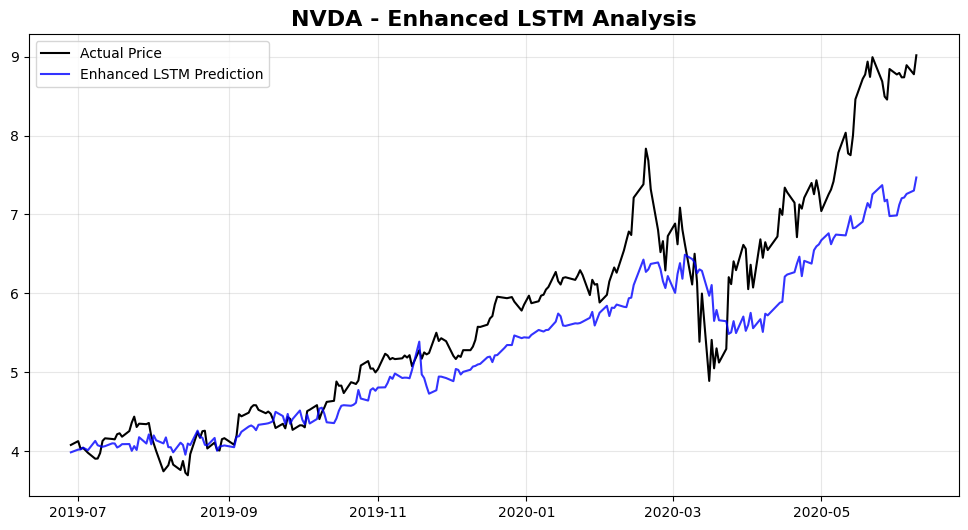

{'Model': 'Enhanced LSTM', 'RMSE': np.float64(0.6600176871821238), 'MAE': 0.4980664831823884, 'MAPE (%)': np.float64(7.758665227722256), 'R-squared': 0.770376115309656, 'Directional_Accuracy': np.float64(52.10084033613446), 'MASE': np.float64(105.93137710686017)}
CPU times: user 355 ms, sys: 29.2 ms, total: 385 ms
Wall time: 396 ms


In [14]:
%%time
print("\n--- Evaluating Best Enhanced Single-Layer LSTM Model ---")
enh_preds = enhanced_model.predict(X_test_enh, verbose=0)

# IMPORTANT: Use the scaler that was fitted to the enhanced data
close_scaler_enh = MinMaxScaler().fit(enhanced_full_data[["Close"]][: len(X_train_enh)])

y_test_enh_scaled = close_scaler_enh.inverse_transform(y_test_enh.reshape(-1, 1))
enh_preds_scaled = close_scaler_enh.inverse_transform(enh_preds)

enhanced_metrics = ut.calculate_metrics(
    y_test_enh_scaled, enh_preds_scaled, "Enhanced LSTM", y_train_enh
)
test_dates_enh = enhanced_full_data.index[-len(y_test_enh_scaled) :]

# Plot the results
print("Plotting results for the best enhanced model...")
ut.plot_non_keras_results(
    y_test_enh_scaled,
    enh_preds_scaled,
    test_dates_enh,
    cfg.STOCK_SYMBOL,
    "Enhanced LSTM",
)

print(enhanced_metrics)

### Multi-Layer Enhanced LSTM Model

In [15]:
%%time
print("\n--- Tuning Multi-Layer Enhanced LSTM Model ---")

# Define the input shape from our ENHANCED training data
input_shape = (X_train_enh.shape[1], X_train_enh.shape[2])

# Instantiate the tuner
tuner_enh_multi_lstm = kt.Hyperband(
    hypermodel=lambda hp: mdl.build_multi_layer_lstm(hp, input_shape=input_shape),
    objective="val_loss",
    max_epochs=20,
    factor=3,
    directory="tuner_results",
    project_name="enhanced_multi_layer_lstm",
    overwrite=True,
)

# Define a callback for early stopping
stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)

# Run the hyperparameter search on the ENHANCED data
print("Starting hyperparameter search on enhanced data...")
tuner_enh_multi_lstm.search(
    X_train_enh,
    y_train_enh,
    epochs=50,
    validation_split=0.2,
    callbacks=[stop_early],
    verbose=2,
)
print("\\nHyperparameter search complete.")

# Get the optimal hyperparameters and the best model
best_hps_enh_multi = tuner_enh_multi_lstm.get_best_hyperparameters(num_trials=1)[0]
multi_enhanced_model = tuner_enh_multi_lstm.get_best_models(num_models=1)[0]

print(
    f"""
---
Optimal Hyperparameters for Multi-Layer Enhanced LSTM:
Units Layer 1: {best_hps_enh_multi.get('units_1')}
Units Layer 2: {best_hps_enh_multi.get('units_2')}
Dropout: {best_hps_enh_multi.get('dropout'):.2f}
Learning Rate: {best_hps_enh_multi.get('learning_rate')}
---
"""
)

Trial 30 Complete [00h 00m 26s]
val_loss: 0.006524319294840097

Best val_loss So Far: 0.004707092419266701
Total elapsed time: 00h 05m 54s
\nHyperparameter search complete.

---
Optimal Hyperparameters for Multi-Layer Enhanced LSTM:
Units Layer 1: 64
Units Layer 2: 96
Dropout: 0.10
Learning Rate: 0.0001
---

CPU times: user 5min 15s, sys: 1min 36s, total: 6min 51s
Wall time: 5min 55s



--- Evaluating Best Multi-Layer Enhanced LSTM Model ---
Plotting results for the best model...
Plot saved to Output/NVDA_Multi-Layer_Enhanced_LSTM_analysis.png


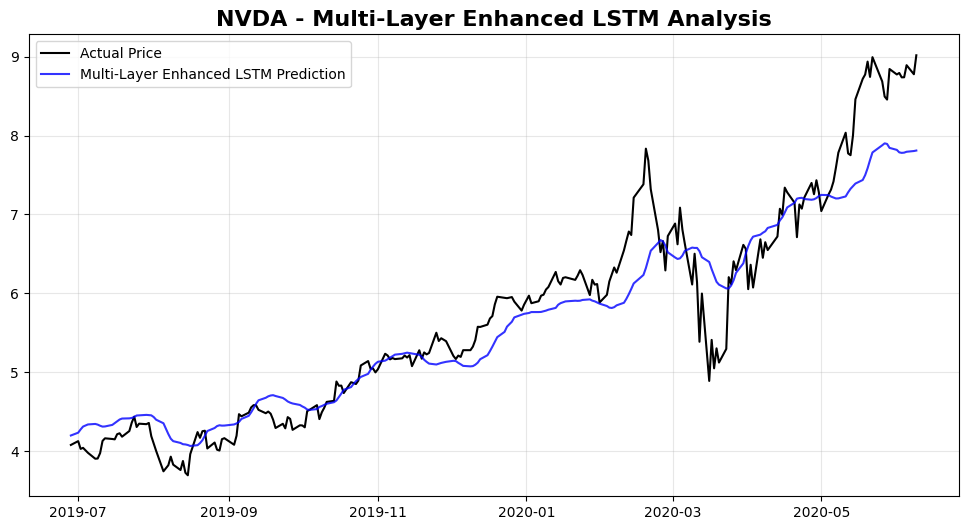

{'Model': 'Multi-Layer Enhanced LSTM', 'RMSE': np.float64(0.45812416011519785), 'MAE': 0.3245058428792275, 'MAPE (%)': np.float64(5.430660341819237), 'R-squared': 0.8893701550809502, 'Directional_Accuracy': np.float64(49.57983193277311), 'MASE': np.float64(69.01759499209457)}
CPU times: user 637 ms, sys: 48.2 ms, total: 685 ms
Wall time: 730 ms


In [16]:
%%time
# Proceed with evaluation using the best ENHANCED model
print("\n--- Evaluating Best Multi-Layer Enhanced LSTM Model ---")
multi_enh_preds = multi_enhanced_model.predict(X_test_enh, verbose=0)

# We can reuse the same scaler fitted for the enhanced data
y_test_enh_scaled = close_scaler_enh.inverse_transform(y_test_enh.reshape(-1, 1))
multi_enh_preds_scaled = close_scaler_enh.inverse_transform(multi_enh_preds)

multi_enhanced_metrics = ut.calculate_metrics(
    y_test_enh_scaled, multi_enh_preds_scaled, "Multi-Layer Enhanced LSTM", y_train_enh
)
test_dates_enh = enhanced_full_data.index[-len(y_test_enh_scaled) :]

# Plot the results
print("Plotting results for the best model...")
ut.plot_non_keras_results(
    y_test_enh_scaled,
    multi_enh_preds_scaled,
    test_dates_enh,
    cfg.STOCK_SYMBOL,
    "Multi-Layer Enhanced LSTM",
)

print(multi_enhanced_metrics)

### Support Vector Machine (SVM) Models

In [17]:
%%time
print("\n--- Preparing Data and Tuning SVM Model ---")
# SVM requires 2D input, so we flatten the sequence data
nsamples, nx, ny = X_train_tech.shape
X_train_svm_tech = X_train_tech.reshape((nsamples, nx * ny))

nsamples, nx, ny = X_test_tech.shape
X_test_svm_tech = X_test_tech.reshape((nsamples, nx * ny))

print(f"Reshaped baseline data for SVM: {X_train_svm_tech.shape}")


--- Preparing Data and Tuning SVM Model ---
Reshaped baseline data for SVM: (2118, 390)
CPU times: user 145 µs, sys: 71 µs, total: 216 µs
Wall time: 166 µs


Building and tuning SVM model with GridSearchCV...
Fitting 3 folds for each of 18 candidates, totalling 54 fits


/opt/anaconda3/envs/tf_metal/lib/python3.10/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/opt/anaconda3/envs/tf_metal/lib/python3.10/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/opt/anaconda3/envs/tf_metal/lib/python3.10/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or

[CV] END ............C=1, epsilon=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ..........C=1, epsilon=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ...........C=1, epsilon=0.1, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ..........C=1, epsilon=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ..........C=1, epsilon=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ............C=1, epsilon=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ...........C=1, epsilon=0.1, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ............C=1, epsilon=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ...........C=1, epsilon=0.1, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END .........C=1, epsilon=0.05, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .........C=1, epsilon=0.05, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .........C=1, epsilon=0.05, gamma=scale, kernel=rbf; total time=   0.1s
[CV] END ...........C=1, eps

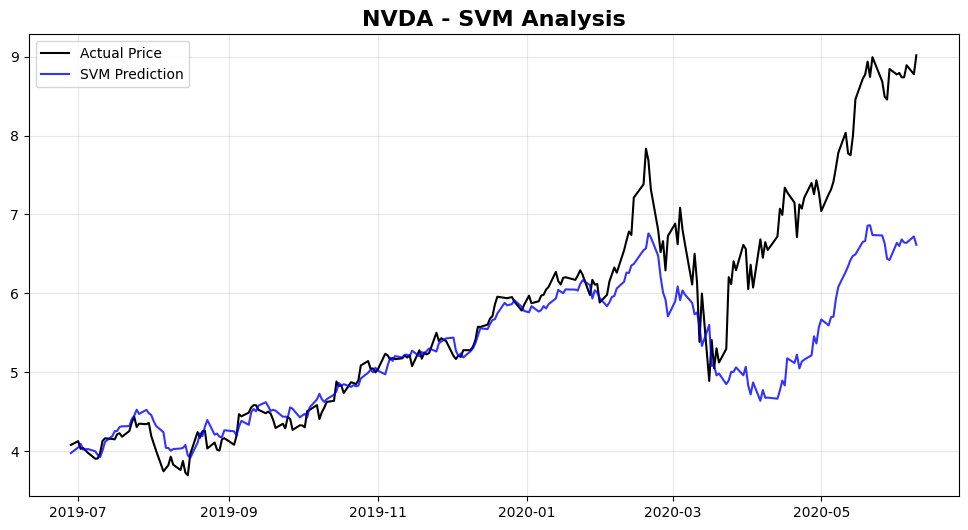

{'Model': 'SVM', 'RMSE': np.float64(0.9294929194615229), 'MAE': 0.5644891237700183, 'MAPE (%)': np.float64(8.205548766639302), 'R-squared': 0.5445946968054025, 'Directional_Accuracy': np.float64(40.7563025210084), 'MASE': np.float64(120.05849070736525)}
CPU times: user 249 ms, sys: 890 ms, total: 1.14 s
Wall time: 4.77 s


In [18]:
%%time
# Build and train the SVM by running the grid search
baseline_svm_model = mdl.build_and_train_svm(X_train_svm_tech, y_train_tech)

# Evaluate the best model found by the tuner
print("\n--- Evaluating Best SVM Model ---")
base_svm_preds = baseline_svm_model.predict(X_test_svm_tech)

base_svm_preds_scaled = close_scaler.inverse_transform(base_svm_preds.reshape(-1, 1))
baseline_svm_metrics = ut.calculate_metrics(
    y_test_tech_scaled, base_svm_preds_scaled, "SVM", y_train_tech
)

# Plot the results
ut.plot_non_keras_results(
    y_test_tech_scaled,
    base_svm_preds_scaled,
    test_dates_tech,
    cfg.STOCK_SYMBOL,
    "SVM",
)

print(baseline_svm_metrics)

### Enhanced Support Vector Machine (SVM) Models

In [19]:
%%time
print("\n--- Preparing Enhanced Data and Tuning Enhanced SVM Model ---")
# Reshape the enhanced data for SVM's 2D input requirement
nsamples, nx, ny = X_train_enh.shape
X_train_svm_enh = X_train_enh.reshape((nsamples, nx * ny))

nsamples, nx, ny = X_test_enh.shape
X_test_svm_enh = X_test_enh.reshape((nsamples, nx * ny))

print(f"Reshaped enhanced data for SVM: {X_train_svm_enh.shape}")


--- Preparing Enhanced Data and Tuning Enhanced SVM Model ---
Reshaped enhanced data for SVM: (2118, 480)
CPU times: user 130 µs, sys: 95 µs, total: 225 µs
Wall time: 198 µs


Building and tuning SVM model with GridSearchCV...
Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] END ..........C=1, epsilon=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ..........C=1, epsilon=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ..........C=1, epsilon=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ............C=1, epsilon=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ...........C=1, epsilon=0.1, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ...........C=1, epsilon=0.1, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ...........C=1, epsilon=0.1, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ............C=1, epsilon=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .........C=1, epsilon=0.05, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ............C=1, epsilon=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .........C=1, epsilon=0.05, gamma=scale, kernel=rbf; total time=   0.

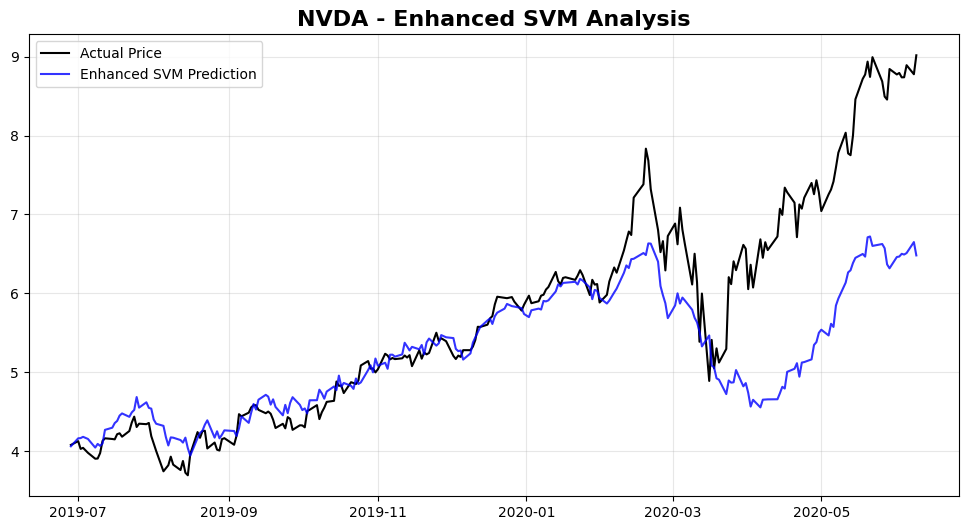

{'Model': 'Enhanced SVM', 'RMSE': np.float64(0.9817465178809852), 'MAE': 0.6091781594900201, 'MAPE (%)': np.float64(9.006862024700709), 'R-squared': 0.4919521110138382, 'Directional_Accuracy': np.float64(47.05882352941176), 'MASE': np.float64(129.56318788182642)}
CPU times: user 184 ms, sys: 112 ms, total: 295 ms
Wall time: 537 ms


In [20]:
%%time
# Build and train the enhanced SVM by running the grid search
enhanced_svm_model = mdl.build_and_train_svm(X_train_svm_enh, y_train_enh)

# Evaluate the best model found by the tuner
print("\n--- Evaluating Best Enhanced SVM Model ---")
enh_svm_preds = enhanced_svm_model.predict(X_test_svm_enh)

# Use the scaler fitted on the enhanced data to inverse the transformation
enh_svm_preds_scaled = close_scaler_enh.inverse_transform(enh_svm_preds.reshape(-1, 1))
enhanced_svm_metrics = ut.calculate_metrics(
    y_test_enh_scaled, enh_svm_preds_scaled, "Enhanced SVM", y_train_tech
)

# Plot the results
ut.plot_non_keras_results(
    y_test_enh_scaled,
    enh_svm_preds_scaled,
    test_dates_enh,
    cfg.STOCK_SYMBOL,
    "Enhanced SVM",
)

print(enhanced_svm_metrics)

### GRU Model

In [21]:
%%time
print("\n--- Tuning Baseline GRU Model ---")

# Define the input shape from our baseline training data
input_shape = (X_train_tech.shape[1], X_train_tech.shape[2])

# Instantiate the tuner for the GRU model
tuner_base_gru = kt.Hyperband(
    hypermodel=lambda hp: mdl.build_gru(hp, input_shape=input_shape),
    objective="val_loss",
    max_epochs=20,
    factor=3,
    directory="tuner_results",
    project_name="baseline_gru",
    overwrite=True,
)

# Define a callback to stop training early
stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)

# Run the hyperparameter search
print("Starting GRU hyperparameter search...")
tuner_base_gru.search(
    X_train_tech,
    y_train_tech,
    epochs=50,
    validation_split=0.2,
    callbacks=[stop_early],
    verbose=2,
)
print("\\nHyperparameter search complete.")

# Get the optimal hyperparameters and the best model
best_hps_base_gru = tuner_base_gru.get_best_hyperparameters(num_trials=1)[0]
baseline_gru_model = tuner_base_gru.get_best_models(num_models=1)[0]

print(
    f"""
---
Optimal Hyperparameters for Baseline GRU:
Units Layer 1: {best_hps_base_gru.get('units_1')}
Units Layer 2: {best_hps_base_gru.get('units_2')}
Dropout: {best_hps_base_gru.get('dropout'):.2f}
Learning Rate: {best_hps_base_gru.get('learning_rate')}
---
"""
)

Trial 30 Complete [00h 00m 19s]
val_loss: 0.011267428286373615

Best val_loss So Far: 0.00551367923617363
Total elapsed time: 00h 06m 10s
\nHyperparameter search complete.

---
Optimal Hyperparameters for Baseline GRU:
Units Layer 1: 64
Units Layer 2: 64
Dropout: 0.30
Learning Rate: 0.001
---

CPU times: user 5min 26s, sys: 1min 39s, total: 7min 5s
Wall time: 6min 12s



--- Evaluating Best Baseline GRU Model ---
Plotting results for the best model...
Plot saved to Output/NVDA_Baseline_GRU_analysis.png


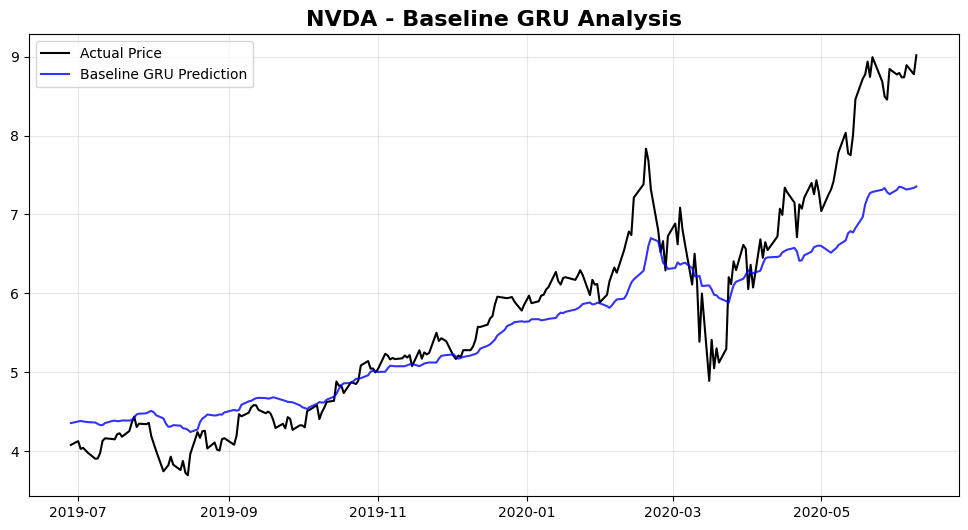

{'Model': 'Baseline GRU', 'RMSE': np.float64(0.5856016694194787), 'MAE': 0.4210184937241686, 'MAPE (%)': np.float64(6.813993505018345), 'R-squared': 0.8192365904908389, 'Directional_Accuracy': np.float64(49.159663865546214), 'MASE': np.float64(89.5444088963627)}
CPU times: user 617 ms, sys: 37.5 ms, total: 655 ms
Wall time: 689 ms


In [22]:
%%time
# Proceed with evaluation using the best model
print("\n--- Evaluating Best Baseline GRU Model ---")
base_gru_preds = baseline_gru_model.predict(X_test_tech, verbose=0)

y_test_tech_scaled = close_scaler.inverse_transform(y_test_tech.reshape(-1, 1))
base_gru_preds_scaled = close_scaler.inverse_transform(base_gru_preds)

baseline_gru_metrics = ut.calculate_metrics(
    y_test_tech_scaled, base_gru_preds_scaled, "Baseline GRU", y_train_tech
)
test_dates_tech = tech_data.index[-len(y_test_tech_scaled) :]

# Plot the results
print("Plotting results for the best model...")
ut.plot_non_keras_results(
    y_test_tech_scaled,
    base_gru_preds_scaled,
    test_dates_tech,
    cfg.STOCK_SYMBOL,
    "Baseline GRU",
)

print(baseline_gru_metrics)

### Enhanced GRU Model

In [23]:
%%time
print("\n--- Tuning Enhanced GRU Model ---")

# Define the input shape from our ENHANCED training data
input_shape = (X_train_enh.shape[1], X_train_enh.shape[2])

# Instantiate the tuner for the Enhanced GRU model
tuner_enh_gru = kt.Hyperband(
    hypermodel=lambda hp: mdl.build_gru(hp, input_shape=input_shape),
    objective="val_loss",
    max_epochs=20,
    factor=3,
    directory="tuner_results",
    project_name="enhanced_gru",  # New project name
    overwrite=True,
)

# Define a callback to stop training early
stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)

# Run the hyperparameter search on the enhanced data
print("Starting Enhanced GRU hyperparameter search...")
tuner_enh_gru.search(
    X_train_enh,
    y_train_enh,
    epochs=50,
    validation_split=0.2,
    callbacks=[stop_early],
    verbose=2,
)
print("\\nHyperparameter search complete.")

# Get the optimal hyperparameters and the best model
best_hps_enh_gru = tuner_enh_gru.get_best_hyperparameters(num_trials=1)[0]
enhanced_gru_model = tuner_enh_gru.get_best_models(num_models=1)[0]

print(
    f"""
---
Optimal Hyperparameters for Enhanced GRU:
Units Layer 1: {best_hps_enh_gru.get('units_1')}
Units Layer 2: {best_hps_enh_gru.get('units_2')}
Dropout: {best_hps_enh_gru.get('dropout'):.2f}
Learning Rate: {best_hps_enh_gru.get('learning_rate')}
---
"""
)

Trial 30 Complete [00h 00m 29s]
val_loss: 0.008870246820151806

Best val_loss So Far: 0.004041953943669796
Total elapsed time: 00h 07m 33s
\nHyperparameter search complete.

---
Optimal Hyperparameters for Enhanced GRU:
Units Layer 1: 128
Units Layer 2: 128
Dropout: 0.20
Learning Rate: 0.0001
---

CPU times: user 6min 34s, sys: 2min 11s, total: 8min 46s
Wall time: 7min 35s



--- Evaluating Best Enhanced GRU Model ---
Plotting results for the best model...
Plot saved to Output/NVDA_Enhanced_GRU_analysis.png


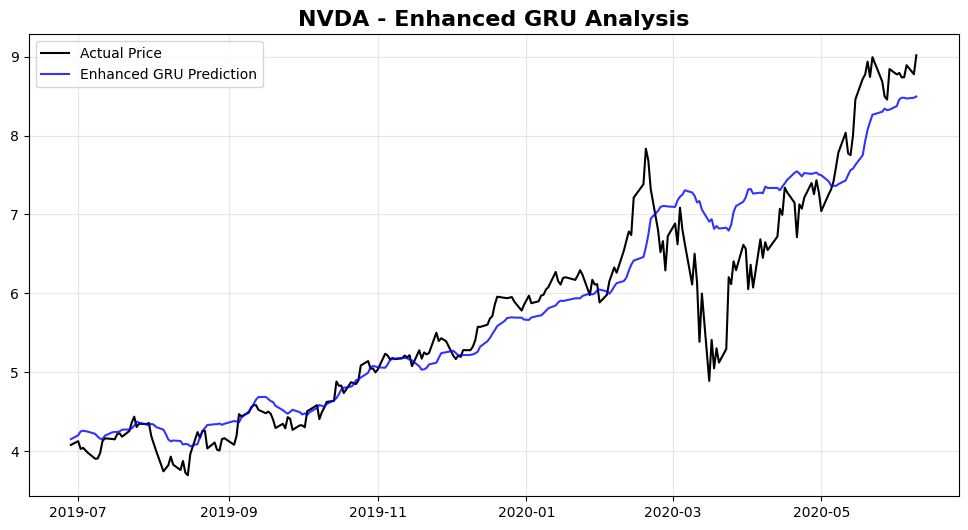

{'Model': 'Enhanced GRU', 'RMSE': np.float64(0.4782525530203615), 'MAE': 0.32098567136660777, 'MAPE (%)': np.float64(5.4793634025894375), 'R-squared': 0.8794352066330767, 'Directional_Accuracy': np.float64(50.0), 'MASE': np.float64(68.26890655676455)}
CPU times: user 624 ms, sys: 188 ms, total: 812 ms
Wall time: 866 ms


In [24]:
%%time
# Proceed with evaluation using the best model
print("\n--- Evaluating Best Enhanced GRU Model ---")
enh_gru_preds = enhanced_gru_model.predict(X_test_enh, verbose=0)

y_test_enh_scaled = close_scaler_enh.inverse_transform(y_test_enh.reshape(-1, 1))
enh_gru_preds_scaled = close_scaler_enh.inverse_transform(enh_gru_preds)

enhanced_gru_metrics = ut.calculate_metrics(
    y_test_enh_scaled, enh_gru_preds_scaled, "Enhanced GRU", y_train_tech
)
test_dates_enh = enhanced_full_data.index[-len(y_test_enh_scaled) :]

# Plot the results
print("Plotting results for the best model...")
ut.plot_non_keras_results(
    y_test_enh_scaled,
    enh_gru_preds_scaled,
    test_dates_enh,
    cfg.STOCK_SYMBOL,
    "Enhanced GRU",
)

print(enhanced_gru_metrics)

### ARIMA Model


--- Finding Best ARIMA Order ---
Searching for the best ARIMA order...
Best ARIMA order found: (4, 1, 2) with AIC: -5260.63


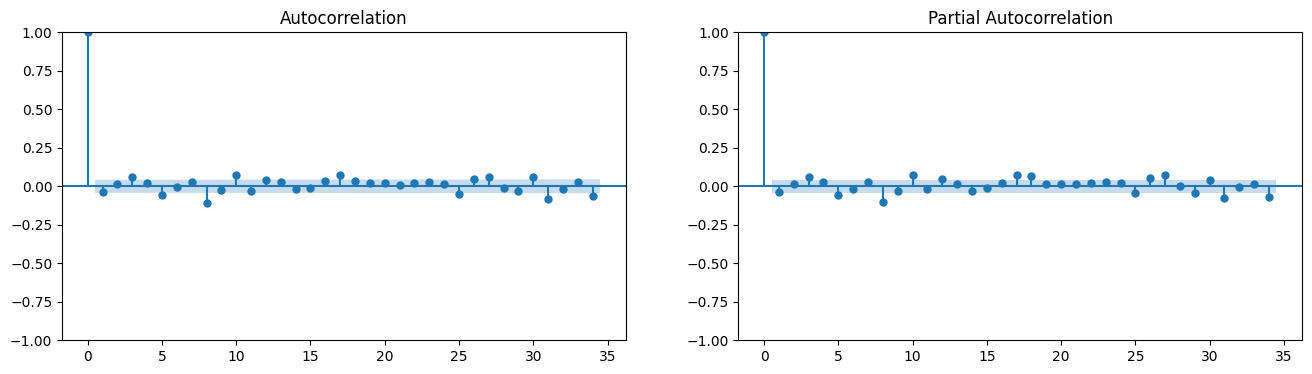

CPU times: user 13.8 s, sys: 193 ms, total: 14 s
Wall time: 14 s


In [25]:
%%time
print("\n--- Finding Best ARIMA Order ---")
# ARIMA works on the unscaled, 1D time series of the target variable
close_prices = tech_data[cfg.BASELINE_TARGET]
train_size = int(len(close_prices) * (1 - cfg.TEST_SIZE))
train_arima, test_arima = close_prices[0:train_size], close_prices[train_size:]

# Find the best order using our new function
best_arima_order = mdl.find_best_arima_order(train_arima)

# Plot ACF and PACF for visual inspection
# This helps to manually verify the p and q values.
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
plot_acf(train_arima.diff().dropna(), ax=axes[0])
plot_pacf(train_arima.diff().dropna(), ax=axes[1], method="ywm")
plt.show()

In [26]:
%%time
print(f"\n--- Running ARIMA Model with best order {best_arima_order} ---")

history = [x for x in train_arima]
arima_predictions = []

print(f"Performing rolling forecast for {len(test_arima)} steps...")
# The tqdm library provides a progress bar, which is useful here

for t in tqdm(range(len(test_arima))):
    # Use the best order found previously for every forecast
    model_arima = mdl.build_and_train_arima(history, order=best_arima_order)
    output = model_arima.forecast()
    yhat = output[0]
    arima_predictions.append(yhat)
    obs = test_arima[t]
    history.append(obs)

print("ARIMA forecast complete.")


--- Running ARIMA Model with best order (4, 1, 2) ---
Performing rolling forecast for 239 steps...


  0%|          | 0/239 [00:00<?, ?it/s]/opt/anaconda3/envs/tf_metal/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
<timed exec>:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
 17%|█▋        | 40/239 [00:31<02:27,  1.35it/s]/opt/anaconda3/envs/tf_metal/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/tf_metal/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found.

ARIMA forecast complete.
CPU times: user 3min 16s, sys: 1.76 s, total: 3min 17s
Wall time: 3min 20s


Plot saved to Output/NVDA_ARIMA_analysis.png


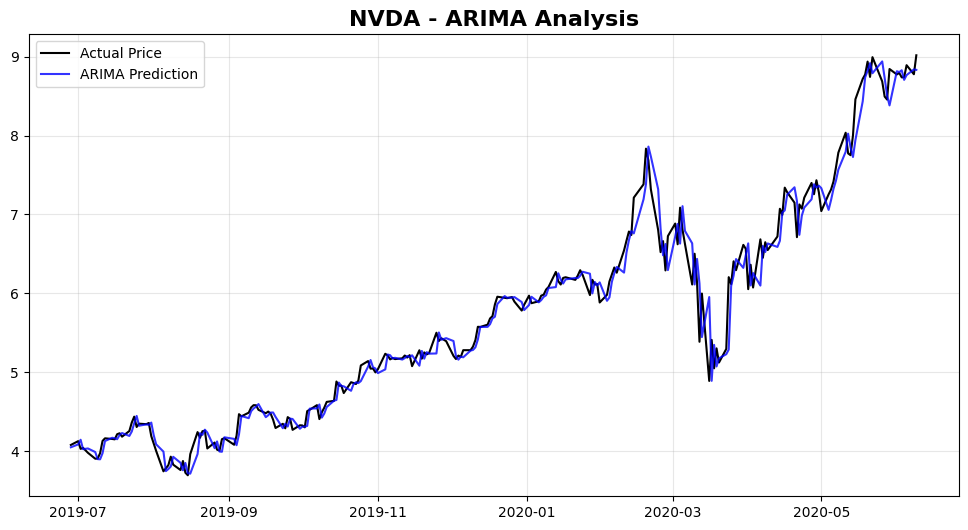

{'Model': 'ARIMA', 'RMSE': np.float64(0.20654486421064347), 'MAE': 0.13809196362763548, 'MAPE (%)': np.float64(2.359834325786231), 'R-squared': 0.977512834653834, 'Directional_Accuracy': np.float64(43.27731092436975), 'MASE': np.float64(4.289641183375679)}
CPU times: user 102 ms, sys: 13.2 ms, total: 115 ms
Wall time: 118 ms


In [27]:
%%time
arima_predictions_np = np.array(arima_predictions).reshape(-1, 1)
y_test_arima_np = np.array(test_arima).reshape(-1, 1)
arima_metrics = ut.calculate_metrics(
    y_test_arima_np, arima_predictions_np, "ARIMA", train_arima
)

ut.plot_non_keras_results(
    y_test_arima_np,
    arima_predictions_np,
    test_arima.index,
    cfg.STOCK_SYMBOL,
    "ARIMA",
)

print(arima_metrics)

### 7. Final Performance Comparison

In [28]:
%%time
naive_preds = np.roll(y_test_tech_scaled, 1)
naive_preds[0] = y_test_tech_scaled[0]
naive_metrics = ut.calculate_metrics(y_test_tech_scaled, naive_preds, "Naive Baseline", y_train_tech)

# --- UPDATED TO INCLUDE ALL MODELS ---
all_metrics_df = pd.DataFrame(
    [
        naive_metrics,
        baseline_metrics,
        enhanced_metrics,
        multi_layer_metrics,
        multi_enhanced_metrics,
        baseline_gru_metrics,
        enhanced_gru_metrics,
        baseline_svm_metrics,
        enhanced_svm_metrics,
        arima_metrics,
    ]
).round(4)

print("\n📊 COMPREHENSIVE PERFORMANCE COMPARISON")
print("-" * 60)
print(all_metrics_df.to_string(index=False))
print("-" * 60)

metrics_to_evaluate = {
    "RMSE": "min",
    "MAE": "min",
    "MAPE (%)": "min",
    "MASE": "min",
    "R-squared": "max",
    "Directional_Accuracy": "max"
}

print("\n🏆 Best Model for Each Metric")
print("-" * 60)
for metric, method in metrics_to_evaluate.items():
    if method == "min":
        # For metrics where lower is better (like RMSE, MAE, MAPE, MASE)
        winner_idx = all_metrics_df[metric].idxmin()
    else:
        # For metrics where higher is better (like R-squared, Directional Accuracy)
        winner_idx = all_metrics_df[metric].idxmax()

    winner_row = all_metrics_df.loc[winner_idx]
    print(f"{metric:<22}: {winner_row['Model']} (Score: {winner_row[metric]:.4f})")
print("-" * 60)


📊 COMPREHENSIVE PERFORMANCE COMPARISON
------------------------------------------------------------
                    Model   RMSE    MAE  MAPE (%)  R-squared  Directional_Accuracy     MASE
           Naive Baseline 0.2105 0.1422    2.4296     0.9766               39.9160  30.2390
        Single-Layer LSTM 0.4773 0.2972    5.1403     0.8799               48.7395  63.2165
            Enhanced LSTM 0.6600 0.4981    7.7587     0.7704               52.1008 105.9314
         Multi-Layer LSTM 0.5605 0.3845    6.5127     0.8344               53.7815  81.7773
Multi-Layer Enhanced LSTM 0.4581 0.3245    5.4307     0.8894               49.5798  69.0176
             Baseline GRU 0.5856 0.4210    6.8140     0.8192               49.1597  89.5444
             Enhanced GRU 0.4783 0.3210    5.4794     0.8794               50.0000  68.2689
                      SVM 0.9295 0.5645    8.2055     0.5446               40.7563 120.0585
             Enhanced SVM 0.9817 0.6092    9.0069     0.4920           

In [29]:
%%time
ranking_df = all_metrics_df.copy()

# Lower is better for these metrics
ranking_df["RMSE_Rank"] = ranking_df["RMSE"].rank(method="min", ascending=True)
ranking_df["MAE_Rank"] = ranking_df["MAE"].rank(method="min", ascending=True)
ranking_df["MAPE_Rank"] = ranking_df["MAPE (%)"].rank(method="min", ascending=True)
ranking_df["MASE_Rank"] = ranking_df["MASE"].rank(method="min", ascending=True)

# Higher is better for these metrics
ranking_df["DA_Rank"] = ranking_df["Directional_Accuracy"].rank(method="min", ascending=False)
ranking_df["R2_Rank"] = ranking_df["R-squared"].rank(method="min", ascending=False)

# Create a total rank score (e.g., based on the most important metrics)
ranking_df["Total_Rank"] = (
        ranking_df["MASE_Rank"] + ranking_df["MAPE_Rank"] + ranking_df["DA_Rank"]
)

final_ranking = ranking_df.sort_values(by="Total_Rank", ascending=True)

print("\n🏆 Overall Model Ranking (Lower Total_Rank is Better)")
print("-" * 60)
print(
    final_ranking[["Model", "Total_Rank", "RMSE", "Directional_Accuracy", "MAPE (%)", "MASE"]]
    .reset_index(drop=True)
    .to_string()
)


🏆 Overall Model Ranking (Lower Total_Rank is Better)
------------------------------------------------------------
                       Model  Total_Rank    RMSE  Directional_Accuracy  MAPE (%)      MASE
0                      ARIMA        10.0  0.2065               43.2773    2.3598    4.2896
1          Single-Layer LSTM        12.0  0.4773               48.7395    5.1403   63.2165
2               Enhanced GRU        12.0  0.4783               50.0000    5.4794   68.2689
3           Multi-Layer LSTM        13.0  0.5605               53.7815    6.5127   81.7773
4  Multi-Layer Enhanced LSTM        13.0  0.4581               49.5798    5.4307   69.0176
5             Naive Baseline        14.0  0.2105               39.9160    2.4296   30.2390
6              Enhanced LSTM        18.0  0.6600               52.1008    7.7587  105.9314
7               Baseline GRU        19.0  0.5856               49.1597    6.8140   89.5444
8                        SVM        27.0  0.9295               40.

Plot saved to Output/NVDA_all_models_comparison.png


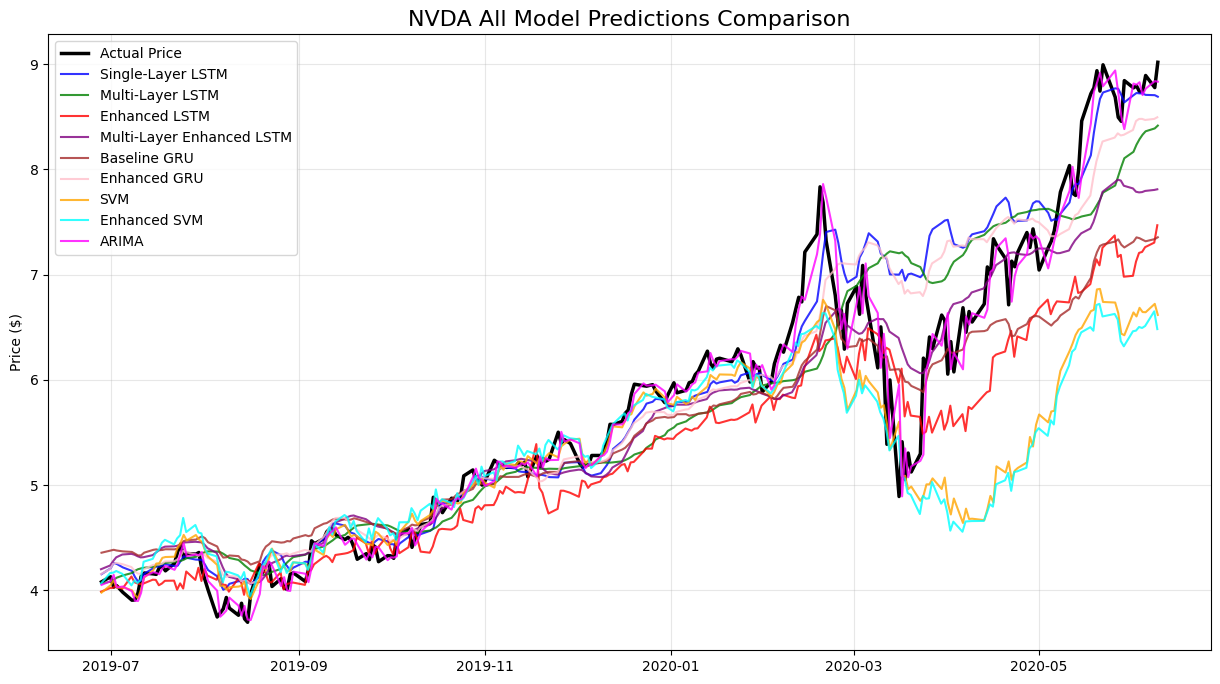

CPU times: user 174 ms, sys: 24.1 ms, total: 198 ms
Wall time: 215 ms


In [32]:
%%time
plot_data = {
    "Actual": {"dates": test_dates_tech, "values": y_test_tech_scaled},
    "Single-Layer LSTM": {"dates": test_dates_tech, "values": base_preds_scaled},
    "Multi-Layer LSTM": {"dates": test_dates_tech, "values": multi_preds_scaled},
    "Enhanced LSTM": {"dates": test_dates_enh, "values": enh_preds_scaled},
    "Multi-Layer Enhanced LSTM": {
        "dates": test_dates_enh,
        "values": multi_enh_preds_scaled,
    },
    "Baseline GRU": {"dates": test_dates_tech, "values": base_gru_preds_scaled},
    "Enhanced GRU": {"dates": test_dates_enh, "values": enh_gru_preds_scaled},
    "SVM": {"dates": test_dates_tech, "values": base_svm_preds_scaled},
    "Enhanced SVM": {"dates": test_dates_enh, "values": enh_svm_preds_scaled},
    "ARIMA": {"dates": test_arima.index, "values": arima_predictions_np},
}

ut.plot_final_comparison(plot_data, cfg.STOCK_SYMBOL, f"{cfg.STOCK_SYMBOL} All Model Predictions Comparison")

Plot saved to Output/NVDA_all_models_comparison.png


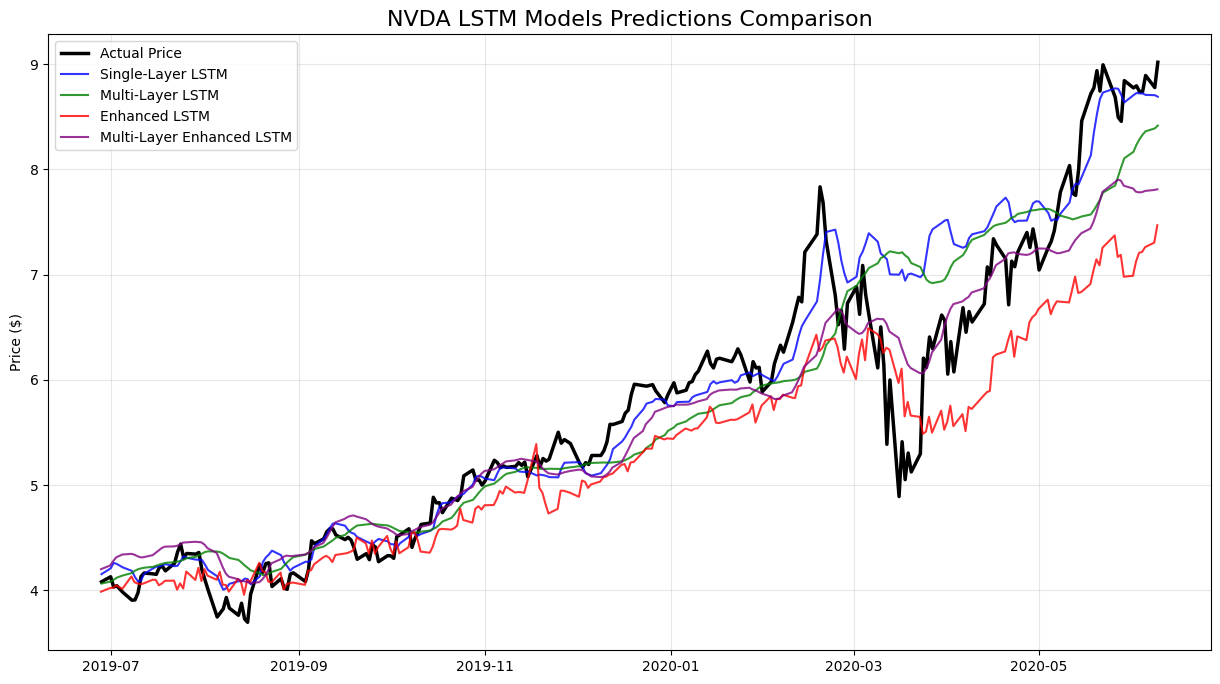

CPU times: user 142 ms, sys: 20.6 ms, total: 163 ms
Wall time: 165 ms


In [38]:
%%time
plot_data = {
    "Actual": {"dates": test_dates_tech, "values": y_test_tech_scaled},
    "Single-Layer LSTM": {"dates": test_dates_tech, "values": base_preds_scaled},
    "Multi-Layer LSTM": {"dates": test_dates_tech, "values": multi_preds_scaled},
    "Enhanced LSTM": {"dates": test_dates_enh, "values": enh_preds_scaled},
    "Multi-Layer Enhanced LSTM": {
        "dates": test_dates_enh,
        "values": multi_enh_preds_scaled,
    },
}

ut.plot_final_comparison(plot_data, cfg.STOCK_SYMBOL, f"{cfg.STOCK_SYMBOL} LSTM Models Predictions Comparison")

In [31]:
try:
    end_time = time.time()
    total_time = end_time - start_time
    print(f"--- Total Notebook Runtime: {total_time:.2f} seconds ---")
except NameError:
    print("⚠️ --- Timer could not be stopped because 'start_time' was not defined.")

--- Total Notebook Runtime: 2175.07 seconds ---
